
<a id='generic-programming'></a>
How to read this lecture…

- If using QuantEcon lectures for the first time on a computer, execute ] add InstantiateFromURL inside of a notebook or the REPL  
- For some notebooks, enable content with “Trust” on the command tab of Jupyter lab  
- Code should execute sequentially if run in a Jupyter notebook  
- Please direct feedback to [contact@quantecon.org](mailto:contact@quantecon.org") or [discourse forum](http://discourse.quantecon.org/)  

# Generic Programming

## Contents

- [Generic Programming](#Generic-Programming)  
  - [Overview](#Overview)  
  - [Exploring Type Trees](#Exploring-Type-Trees)  
  - [Number, Real, and Algebraic Structures](#Number,-Real,-and-Algebraic-Structures)  
  - [Understanding Multiple Dispatch in Julia](#Understanding-Multiple-Dispatch-in-Julia)  


    I find OOP methodologically wrong. It starts with classes. It is as if mathematicians would start with axioms. You do not start with axioms - you start with proofs. Only when you have found a bunch of related proofs, can you come up with axioms. You end with axioms. The same thing is true in programming: you have to start with interesting algorithms. Only when you understand them well, can you come up with an interface that will let them work. - Alexander Stepanov

## Overview

In this lecture we delve more deeply into the structure of Julia, and in particular into

- abstract and concrete types  
- the type tree  
- designing and using generic interfaces  
- the role of generic interfaces in Julia performance  


Understanding them will help you

- Design code that matches the “white-board” mathematics  
- Create code that can use (and be used) by a variety of other packages  
- Write “well organized” Julia code that’s easy to read, modify, maintain and debug  
- Improve the speed at which your code runs  

### Generic Programming as an Attitude

From Mathematics to Generic Programming (Stefanov and Rose)


    Generic programming is an approach to programming that focuses on designing algorithms and data structures so that they work in the most general setting without loss of efficiency… Generic programming is more of an attitude toward programming than a particular set of tools.**

In that sense, it is important to think of generic programming not as a set of rules to apply about decomposing taxonomies of abstractions, but rather as an interactive approach in attempting to uncover generality without any performance overhead

As we will see, the core approach is to treat data-structures and algorithms as loosely coupled, and is in direct contrast to the “isa” approach of object-oriented programming

### Setup

In [1]:
using InstantiateFromURL
activate_github("QuantEcon/QuantEconLecturePackages", tag = "v0.9.0") # activate the QuantEcon environment

using LinearAlgebra, Statistics, Compat # load common packages

## Exploring Type Trees

The connection between data-structures and the algorithms which operate on them is handled the through the type system

Concrete types (i.e. Float64 or Array{Float64, 2}) is the data-structure we have in mind for working with algorithms, and the  abstract types we have seen before (e.g. Number and AbstractArray) provide the mapping a particular set of data structures to a particular algorithm

At the root of all types is Any

There are a (very limited) set of operations which are available for Any, including a show function and typeof

In [2]:
using Distributions
x = 1
y = Normal()
@show x #
@show y
@show typeof(x)
@show typeof(y)
@show supertype(typeof(x))
@show typeof(x) |> supertype # pipe operator(|>), just applies a function to another function
@show supertype(typeof(y));

x = 1
y = Normal{Float64}(μ=0.0, σ=1.0)
typeof(x) = Int64
typeof(y) = Normal{Float64}
supertype(typeof(x)) = Signed
typeof(x) |> supertype = Signed
supertype(typeof(y)) = Distribution{Univariate,Continuous}


We will investigate some of the sub-types of Any

Beyond the typeof and supertype, a few other useful tools for analyzing the tree of types were discussed in [this lecture](introduction_to_types)

In [3]:
using Base: show_supertypes # import the function from the `Base` package

show_supertypes(Int64)

Int64 <: Signed <: Integer <: Real <: Number <: Any

In [4]:
subtypes(Integer)

3-element Array{Any,1}:
 Bool    
 Signed  
 Unsigned

Using the subtypes function, we can traverse the type tree below a particular type

In [5]:
# From https://github.com/JuliaLang/julia/issues/24741
function subtypetree(t, level=1, indent=4)
        if level == 1
            println(t)
        end
        for s in subtypes(t)
            println(join(fill(" ", level * indent)) * string(s)) # print type
            subtypetree(s, level+1, indent) #recursively print the next types, indenting
        end
    end

subtypetree (generic function with 3 methods)

Using this function, we can see all of the current types in memory below Number in the tree

In [6]:
subtypetree(Number) # warning: Don't use this function on ``Any``!

Number
    Complex
    Real
        AbstractFloat
            BigFloat
            Float16
            Float32
            Float64
        AbstractIrrational
            Irrational
        Integer
            Bool
            Signed
                BigInt
                Int128
                Int16
                Int32
                Int64
                Int8
            Unsigned
                UInt128
                UInt16
                UInt32
                UInt64
                UInt8
        Rational


For the most part, all of the “leaves” will be concrete types

### Unlearning Object Oriented (OO) Programming (Advanced)

(see [Types](https://docs.julialang.org/en/v1/manual/types/#man-types-1) for more on OO vs. generic types)


    If you have never used programming languages such as C++, Java, Python, etc., then the type hierarchies above may seem unfamiliar and abstract–but there is no need to read this section

Otherwise, if you have used object-oriented programming (OOP) in those languages, then some of the concepts in these lecture notes will appear familiar

**Don’t be fooled!**

The superficial similarity can lead to misuse: types are *not* just classes with poor encapsulation, and methods are not simply the equivalent to member functions with the order of arguments swapped

In particular, previous OO knowledge often leads people to write Julia code such as

In [7]:
# BAD! Replicating an OO design in Julia
mutable struct MyModel
    a::Float64
    b::Float64
    algorithmcalculation::Float64

    MyModel(a, b) = new(a, b, 0.0) # an inner constructor
end

function myalgorithm!(m::MyModel, x)
    m.algorithmcalculation = m.a + m.b + x # some algorithm
end

function set_a!(m::MyModel, a)
    m.a = a
end

m = MyModel(2.0, 3.0)
x = 0.1
set_a!(m, 4.1)
myalgorithm!(m, x)
@show m.algorithmcalculation;

m.algorithmcalculation = 7.199999999999999


You may think to yourself that the above code is similar to OO, except that
* reverse the first argument, i.e. myalgorithm!(m, x) instead of the object-oriented m.myalgorithm!(x)
* cannot control encapsulation of the fields a, b, but you can add getter/setters like set_a
* do not have concrete inheritance

While this sort of programming is possible, it is (verbosely) missing the point of Julia and the power of generic programming

It may be helpful to review the traditional pillars of OOP
* *`Abstraction <https://en.wikipedia.org/wiki/Abstraction_(computer_science)#Abstraction_in_object_oriented_programming>`_:* In OO one develops a taxonomy of hierarchical “is-a” relationships as “classes”, where the key abstraction involves describing interactions between the self-contained “classes”
* *`Encapsulation <https://en.wikipedia.org/wiki/Encapsulation_(computer_programming)>`_:* Most OO code has fully mutable classes, where access to the internals is tightly controlled since the class manages its own state
* *`Inheritance <https://en.wikipedia.org/wiki/Inheritance_(object-oriented_programming)>`_* Code reuse in OO is achieved through adding a new class to the tree and inheriting some of the behavior of the parent class.
* *`Polymorphism <https://en.wikipedia.org/wiki/Polymorphism_(computer_science)>`_:*  The abstract “is-a” relationships between types in a taxonomy provide a way to have the same function change its behavior given the particular type

With Julia
* You will realize you will do no “encapsulation” or “inheritance”, and polymorphism will be fundamentally different
* Abstraction is primarily achieved through keeping the data and algorithms that operate on them as orthogonal as possible–in contrast to OOP
* The supertypes in Julia are simply used for selecting which specialized algorithm to use (i.e. part of generic polymorphism) and have nothing to do with OO inheritance

#### Iterative Design of Abstractions

As its essence, the design of generic software is that you will start with creating algorithms which are largely orthogonal to concrete types, and in the process you will discover commonality which leads to abstract types with informally defined functions operating on them

This design is in direct contrast to object-oriented design and analysis ([OOAD](https://en.wikipedia.org/wiki/Object-oriented_analysis_and_design)), where you specify a taxonomies of types, add operations to those types, and then move down to various levels of specialization (where algorithms are embedded at points within the taxonomy, and potentially specialized with inheritance)

In the examples that follow, we will show for exposition the hierarchy of types and the algorithms operating on them, but the reality is that the algorithms are often designed first, and the types came later
.. However,  we apologize in the example we confuse things somewhat by jumping to the axioms first for expositoin

### Distributions

First, lets consider working with “distributions”

If we consider mathematical “distributions” that we will use in our algorithms, they may include (1) drawing random numbers for Monte-carlo methods; (2) using the pdf or cdf in various calculations

In that sense, some code may be useful in distributions where a pdf is not necessarily defined or meaningful

The process of using concrete distributions in these sorts of applications led to the creation of the Distributions.jl package

Lets examine the tree of types for a Normal distribution

In [8]:
using Distributions
d1 = Normal(1.0, 2.0) # an example type to explore
@show d1
show_supertypes(typeof(y))

d1 = Normal{Float64}(μ=1.0, σ=2.0)
Normal{Float64} <: Distribution{Univariate,Continuous} <: Sampleable{Univariate,Continuous} <: Any

The Sampleable{Univariate,Continuous} type has a limited number of functions, chiefly the ability to draw a random number

In [9]:
@show rand(d1);

rand(d1) = 0.3722020115317156


The purpose of that abstract type is to provide an interface for drawing from a variety of distributions, some of which may not have a well-defined predefined pdfs

If you were writing a function to simulate a stochastic process with an arbitrary iid shocks, where you did not need to assume an existing of a pdf etc., this is a natural candidate

For example, to simulate $ x_{t+1} = a x_t + b \epsilon_{t+1} $ where $ \epsilon \sim D $ for some $ D $ which allows drawing random values

In [10]:
function simulateprocess(x₀; a = 1.0, b = 1.0, N = 5, d::Sampleable{Univariate,Continuous})
    x = zeros(typeof(x₀), N+1) # preallocate vector, careful on the type
    x[1] = x₀
    for t in 2:N+1
        x[t] = a * x[t-1] + b * rand(d) # draw
    end
    return x
end
@show simulateprocess(0.0, d=Normal(0.2, 2.0));

simulateprocess(0.0, d=Normal(0.2, 2.0)) = [0.0, 5.06553, 3.55045, 5.28092, 4.71885, 4.60576]


# @show simulateprocess(0.0, d=Normal(0.2, 2.0)); #add example of something without pdfThe Sampleable{Univariate,Continuous} and, especially, the Sampleable{Multivariate,Continuous} abstract types are useful generic interfaces for monte-carlo and Bayesian methods, in particular, where you can often draw from a distribution, but can do little else

Moving down the tree, the Distributions{Univariate, Continuous} abstract type has certain functions we would expect to operate with it

These match the mathematics, such as pdf, cdf, quantile, support, minimum, maximum and a few others

In [11]:
d1 = Normal(1.0, 2.0)
d2 = Exponential(0.1)
@show d1
@show d2
@show supertype(typeof(d1))
@show supertype(typeof(d2))

@show pdf(d1, 0.1)
@show pdf(d2, 0.1)
@show cdf(d1, 0.1)
@show cdf(d2, 0.1)
@show support(d1)
@show support(d2)
@show minimum(d1)
@show minimum(d2)
@show maximum(d1)
@show maximum(d2);

d1 = Normal{Float64}(μ=1.0, σ=2.0)
d2 = Exponential{Float64}(θ=0.1)
supertype(typeof(d1)) = Distribution{Univariate,Continuous}
supertype(typeof(d2)) = Distribution{Univariate,Continuous}
pdf(d1, 0.1) = 0.18026348123082397
pdf(d2, 0.1) = 3.6787944117144233
cdf(d1, 0.1) = 0.32635522028792
cdf(d2, 0.1) = 0.6321205588285577
support(d1) = RealInterval(-Inf, Inf)
support(d2) = RealInterval(0.0, Inf)
minimum(d1) = -Inf
minimum(d2) = 0.0
maximum(d1) = Inf
maximum(d2) = Inf


You could create your own Distributions{Univariate, Continuous} type, if you implemented all of those functions, as is described in [the documentation](https://juliastats.github.io/Distributions.jl/latest/extends.html)

If you fulfill all of the conditions of a particular interface, you (or anyone else) could use code written for the abstract Distributions{Univariate, Continuous} type without any modifications

As an example, consider the [StatPlots](https://github.com/JuliaPlots/StatPlots.jl) package

┌ Info: Precompiling StatPlots [60ddc479-9b66-56df-82fc-76a74619b69c]
└ @ Base loading.jl:1186
┌ Info: Precompiling Widgets [cc8bc4a8-27d6-5769-a93b-9d913e69aa62]
└ @ Base loading.jl:1186
┌ Info: Precompiling Clustering [aaaa29a8-35af-508c-8bc3-b662a17a0fe5]
└ @ Base loading.jl:1186
┌ Info: Recompiling stale cache file /Users/arnavsood/.julia/compiled/v1.0/KernelDensity/4QyGx.ji for KernelDensity [5ab0869b-81aa-558d-bb23-cbf5423bbe9b]
└ @ Base loading.jl:1184


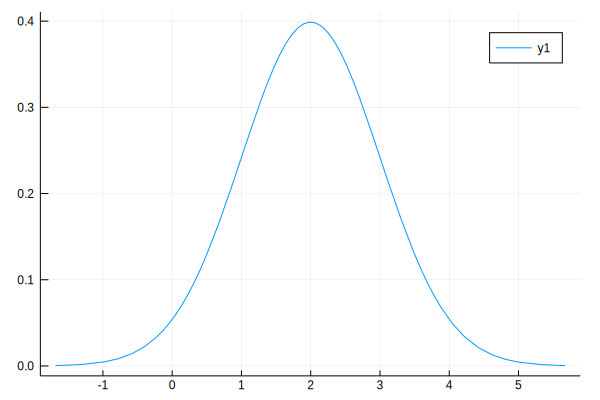

In [12]:
using StatPlots
d = Normal(2.0, 1.0)
plot(d) # note no other arguments!

The plot function when applied to anything which is a subtype of Distributions{Univariate, Continuous}, will display the pdf using the minimum and maximum applied to the value

To demonstrate this, lets create our own distribution type

In [13]:
struct OurTruncatedExponential <: Distribution{Univariate,Continuous}
    α::Float64
    xmax::Float64
end
Distributions.pdf(d::OurTruncatedExponential, x) = d.α *exp(-d.α * x)/exp(-d.α * d.xmax)
Distributions.minimum(d::OurTruncatedExponential) = 0
Distributions.maximum(d::OurTruncatedExponential) = d.xmax
# ... should do all of them, but this was enough

To demonstrate this

In [14]:
d = OurTruncatedExponential(1.0,2.0)
@show minimum(d), maximum(d)
@show support(d) # why does this work?

(minimum(d), maximum(d)) = (0, 2.0)
support(d) = RealInterval(0.0, 2.0)


RealInterval(0.0, 2.0)

Curiously, you will note that the support function is operational, even though we did not provide one

This is another example of the power of multiple dispatch and generic programming

In the background, the Distributions.jl package  has something like the following implemented

```julia
    Distributions.support(d::Distribution) = RealInterval(minimum(d), maximum(d))
```


Hence, since OurTruncatedExponential <: Distribution, and we implemented minimum and maximum, calls to support gets this implementation

Of course, while we should implement more of the func

That turns out to be enough for us to use the StatPlots package

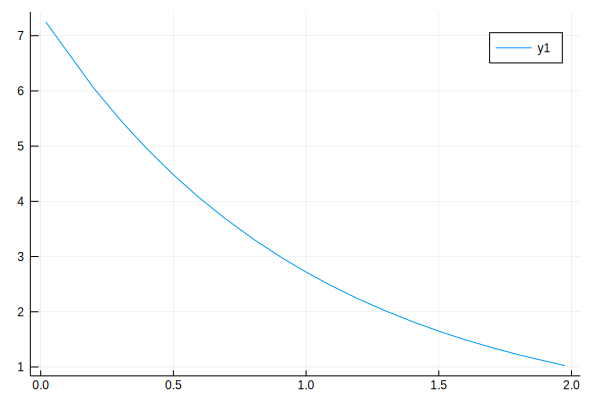

In [15]:
plot(d) # uses the generic code!

A few things to point out

- Even if it worked for StatPlots, our implementation is incomplete, as we haven’t fulfilled all of the requirements of a Distribution  
- We also did not implement the rand function, which means we are breaking the implicit contract of the Sampleable abstract type  
- It turns out that there is a better way to to this precise thing already built into Distributions  

typeof(d) = Truncated{Exponential{Float64},Continuous}


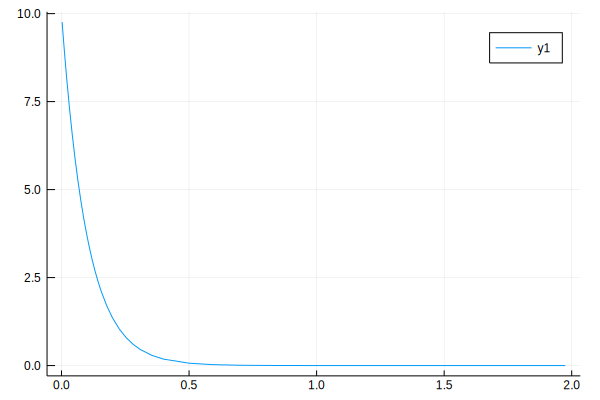

In [16]:
d = Truncated(Exponential(0.1), 0.0, 2.0)
@show typeof(d)
plot(d)

Which, of course, is also written in terms of the generic type.. code-block:: juliad = Truncated(OurTruncatedExponential(1.0,2.0), 0.1, 1.5) # truncate again!@show typeof(d)plot(d)Crucially, the ``StatPlots.jl``, ``Distributions.jl``, and our code are **separate**, so this is a composition of different packages that have simply agreed on a set of appropriate functions and abstract typesThis is the power of generic programming in general, and Julia in particular: you can combine and compose completely separate packages and code, as long as there is an agreement on abstract types and functions

## Number, Real, and Algebraic Structures

(Special thank you to Jeffrey Sarnoff)

In mathematics, a [Ring](https://en.wikipedia.org/wiki/Ring_(mathematics)) is a set with two binary operators ($ + $ and $ \cdot $, called the additive and multiplicative operators) where there is an
* additive operator is associative and commutative
* multiplicative operator is associative and and distributive with respect to the additive operator
* additive identity element, usually denoted 0 such that $ a + 0 = a $ for any $ a $ in the set
* additive inverse of each element, i.e. $ -a $ such that $ a + (-a) = 0 $
* multiplicative identity element, usually denoted 1 such that $ a \cdot 1 = a $

This is skipping over a few other key parts of the definition, but it is also useful to say what is not needed
* A total or partial ordering is not required (i.e. there does not need to be any meaningful < operator defined)
* A multiplicative inverse is not required

This algebraic structure provides motivation for the abstract Number type in Julia
**Remark** We use motivation here because they are not formally connected and the mapping is imperfect
* The main difficulty when dealing with numbers that can be concretely created on a computer is that the closure requirements are difficult to ensure (e.g. floating points have finite numbers of bits of information)

Let typeof(a) = typeof(b) = T <: Number, then under an implicit definition of the **generic interfac** for Number the following must be defined
* the additive operator: a + b
* the multiplicative operator: a * b
* an additive inverse operator: -a
* an inverse operation for addition a - b = a + (-b)
* an additive identity: zero(T) or zero(a) for convenience
* a multiplicative identity: one(T) or one(a) for convenience

The core of generic programming is that, given the knowledge that a value is of type Number, we can write to that generic interface

To demonstrate these for a complex number or a big integer (i.e., two types other than the standard Float64 Int64 you may associate with numbers)

In [17]:
a = 1.0 + 1.0im
b = 0.0 + 2.0im
@show typeof(a)
@show typeof(a) <: Number
@show a + b
@show a * b
@show -a
@show a - b
@show zero(a)
@show one(a);

typeof(a) = Complex{Float64}
typeof(a) <: Number = true
a + b = 1.0 + 3.0im
a * b = -2.0 + 2.0im
-a = -1.0 - 1.0im
a - b = 1.0 - 1.0im
zero(a) = 0.0 + 0.0im
one(a) = 1.0 + 0.0im


In [18]:
a = BigInt(10)
b = BigInt(4)
@show typeof(a)
@show typeof(a) <: Number
@show a + b
@show a * b
@show -a
@show a - b
@show zero(a)
@show one(a);

typeof(a) = BigInt
typeof(a) <: Number = true
a + b = 14
a * b = 40
-a = -10
a - b = 6
zero(a) = 0
one(a) = 1


Thinking back to the mathematical motivation, a [Field](https://en.wikipedia.org/wiki/Field_(mathematics)) is an Ring with a few additional properties, among them
* a multiplicative inverse: $ a^{-1} $
* an inverse operation for multiplication: $ a / b = a \cdot b^{-1} $
* a (not strictly required) total ordering operation: $ a < b $

where the  [total ordering](https://en.wikipedia.org/wiki/Total_order#Strict_total_order)  operation would fulfill the requirements for a Totally Ordered Field

This type gives some motivation for the operations and properties of the Real type

Of course, Complex{Float64} <: Number but not Real, which makes sense since those operations are not defined for the basic Complex number type in mathematics

These operations are implemented in any subtype of Real through
* the multiplicative inverse: inv(a)
* the multiplicative inverse operation: a / b = a * inv(b)
* an ordering a < b

To demonstrate with the Rational type

In [19]:
a = 1 // 10
b = 4 // 6
@show typeof(a)
@show typeof(a) <: Number
@show typeof(a) <: Real
@show inv(a)
@show a / b
@show a < b;

typeof(a) = Rational{Int64}
typeof(a) <: Number = true
typeof(a) <: Real = true
inv(a) = 10//1
a / b = 3//20
a < b = true


**Remark** Here we see where and how the precise connection to the mathematics for number types breaks down for practical reasons, in particular
* Integer types (i.e. Int64 <: Integer) do not have a a multiplicative inverse with closure in the set
* However, it is necessary in practice for integer division to be defined, and return back a member of the Reals
* This is called [type promotion](https://docs.julialang.org/en/v1/manual/conversion-and-promotion/#Promotion-1), where a type can be converted to another to ensure an operation is possible by direct conversion between types (i.e. it can be independent of the type hierarchy)

We should not think of the breaks in the connection between the underlying algebraic structures and the code as a failure of the language or design, but rather that the underlying algorithms for use on a computer do not perfectly fit the algebraic structures

Moving further down the tree of types provides more operations, which start to become more tied to the computational implementation than the mathematics

For example, floating point numbers all have a machine precision below which there is no way to further differentiate numbers

In [20]:
@show Float64 <: AbstractFloat
@show BigFloat <: AbstractFloat
@show eps(Float64)
@show eps(BigFloat);

Float64 <: AbstractFloat = true
BigFloat <: AbstractFloat = true
eps(Float64) = 2.220446049250313e-16
eps(BigFloat) = 1.727233711018888925077270372560079914223200072887256277004740694033718360632485e-77


### Example: isless

The isless function also has multiple methods

First let’s try with integers

In [21]:
@which isless(1, 2)

isless(x::Real, y::Real) in Base at operators.jl:338

As we saw previously, the Real data type is an *abstract* type, and encompasses both floats and integers

If we go to the provided link in the source, we see the entirety of the function is

```julia
isless(x::Real, y::Real) = x<y
```


That is, for any values where typeof(x) <: Real and typeof(y) <: Real, the definition relies on <

We know that < is defined for the types because it is part of the informal interface for the Real abstract type

Note that this is not defined for Number because not all Number types have the < operator defined (e.g. Complex)

Of course, in order to generate fast code,

In [22]:
isless(1.0, 2.0)  # Applied to two floats

true

In [23]:
@which isless(1.0, 2.0)

isless(x::Float64, y::Float64) in Base at float.jl:459

Note that the reason  Float64 <: Real

### Functions, and Function-Like Types

Another common example of the separation between data structures and algorithms is the use of functions

Syntactically, we should consider a univariate “function” any f that can call an argument x as f(x) for a general x

For example, we can use a standard function

integrate(f, 0.0, 1.0) = (0.3333333333333333, 5.551115123125783e-17)


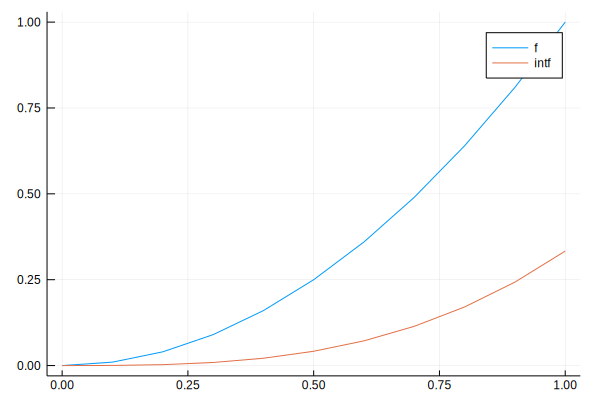

In [24]:
using QuadGK
const integrate = quadgk # example of setting an alias
f(x) = x^2
@show integrate(f, 0.0, 1.0) #integral

function plotfunctions(f)
    intf(x) = integrate(f, 0.0, x)[1] #int_0^x f(x) dx

    x = 0:0.1:1.0
    f_x = f.(x)
    plot(x, f_x, label="f")
    plot!(x, intf.(x), label="intf")
end
plotfunctions(f) # call with our f

Of course, polynomials are also functions in every important sense

p = Poly(2 - 5*x + 2*x^2)
p(1.0) = -1.0


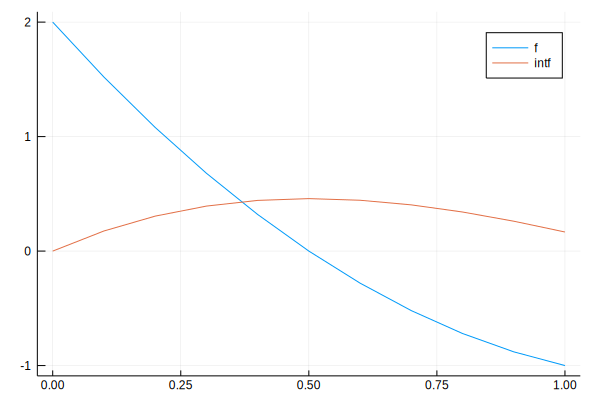

In [25]:
using Polynomials
p = Poly([2, -5, 2], :x) # :x just gives a symbol for display
@show p
@show p(1.0) # call like a function

plotfunctions(p) # same generic function

Or Interpolations

f_int(1.0) = 1.0


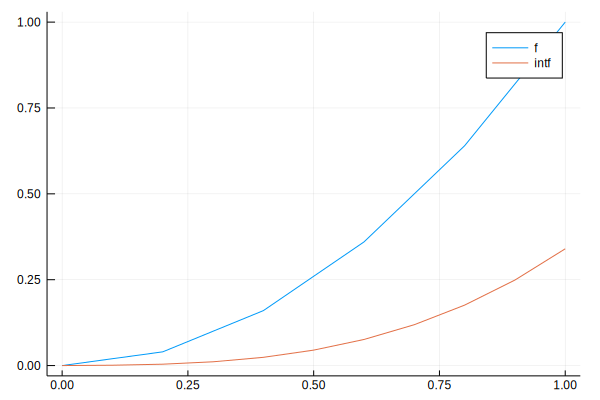

In [26]:
using Interpolations
x = 0.0:0.2:1.0
f(x) = x^2
f_int = LinearInterpolation(x, f.(x)) # interpolating those points
@show f_int(1.0) # call like a function

plotfunctions(f_int) # same generic function

Note that the same generic plotfunctions could use any variable passed to it that “looks” like a function, i.e. can call f(x)

This sort of typing and design–generic but without any declarations–is usually called [duck typing](https://en.wikipedia.org/wiki/Duck_typing)

If you need to make an existing type callable, see [Function Like Objects](https://docs.julialang.org/en/v1/manual/methods/#Function-like-objects-1)

### Limitations of these Structures in Julia

You will notice that types in Julia represent a tree with Any at the root

The tree structure has worked well for the above examples, but it doesn’t allow us to associate multiple categorizations of types

For example, a semi-group type would be very useful for a writing generic code (e.g. continuous-time solutions for ODEs and matrix-free methods) but cannot be implemented rigorously since the Matrix type is a semi-group, but it is also an AbstractArray

The main way to implement this in a generic language is with a feature called traits

See the [original discussion](https://github.com/JuliaLang/julia/issues/2345#issuecomment-54537633) and an [example of a package to facilitate the pattern](https://github.com/mauro3/SimpleTraits.jl)

A complete description of the Traits patterns as the natural evolution of Multiple Dispatch is given in this [blog post](https://white.ucc.asn.au/2018/10/03/Dispatch,-Traits-and-Metaprogramming-Over-Reflection.html)

## Understanding Multiple Dispatch in Julia

This section provides more background on how methods, functions, and types are connected

### Methods and Functions

The precise data type is important, for reasons of both efficiency and mathematical correctness

For example consider 1 + 1 vs. 1.0 + 1.0 or [1 0] + [0 1]

On a CPU, integer and floating point addition are different things, using a different set of instructions

Julia handles this problem by storing multiple, specialized versions of functions like addition, one for each data type or set of data types

These individual specialized versions are called **methods**

When an operation like addition is requested, the Julia compiler inspects the type of data to be acted on and hands it out to the appropriate method

This process is called **multiple dispatch**

Like all “infix” operators, 1 + 1 has the alternative syntax +(1, 1)

In [27]:
+(1, 1)

2

This operator + is itself a function with multiple methods

We can investigate them using the @which macro, which shows the method to which a given call is dispatched

In [28]:
x, y = 1.0, 1.0
@which +(x, y)

+(x::Float64, y::Float64) in Base at float.jl:395

We see that the operation is sent to the + method that specializes in adding
floating point numbers

Here’s the integer case

In [29]:
x, y = 1, 1
@which +(x, y)

+(x::T, y::T) where T<:Union{Int128, Int16, Int32, Int64, Int8, UInt128, UInt16, UInt32, UInt64, UInt8} in Base at int.jl:53

This output says that the call has been dispatched to the + method
responsible for handling integer values

(We’ll learn more about the details of this syntax below)

Here’s another example, with complex numbers

In [30]:
x, y = 1.0 + 1.0im, 1.0 + 1.0im
@which +(x, y)

+(z::Complex, w::Complex) in Base at complex.jl:266

Again, the call has been dispatched to a + method specifically designed for handling the given data type

Example 3^^^^^^^^^^^^^^The function ``isfinite()`` has multiple methods too.. code-block:: julia@which isfinite(1) # Call isfinite on an integer.. code-block:: julia@which isfinite(1.0) # Call isfinite on a floatHere ``AbstractFloat`` is another abstract data type, this time encompassing all floatsWe can list all the methods of ``isfinite`` as follows.. code-block:: juliamethods(isfinite)We'll discuss some of the more complicated data types you see here later on

#### Adding Methods

It’s straightforward to add methods to existing functions

For example, we can’t at present add an integer and a string in Julia (i.e. 100 + "100" is not valid syntax)

This is sensible behavior, but if you want to change it there’s nothing to stop you:

In [31]:
import Base: +  #  Gives access to + so that we can add a method

+(x::Integer, y::String) = x + parse(Int, y)

@show +(100, "100")
@show 100 + "100"; #equivalent

100 + "100" = 200
100 + "100" = 200


If we write a function that can handle either floating point or integer arguments and then call it with floating point arguments, a specialized method for applying our function to floats will be constructed and stored in memory* Inside the method, operations such as addition, multiplication, etc. will be specialized to their floating point versionsIf we next call it with integer arguments, the process will be repeated but nowspecialized to integers* Inside the method, operations such as addition, multiplication, etc. will be specialized to their integer versionsSubsequent calls will be routed automatically to the most appropriate methodComments on Efficiency------------------------We'll see how this enables Julia to easily generate highly efficient machine code in :doc:`later on <need_for_speed>`

### Understanding the Compilation Process

We can now be a little bit clearer about what happens when you call a function on given types

Suppose we execute the function call f(a, b) where a and b
are of concrete types S and T respectively

The Julia interpreter first queries the types of a and b to obtain the tuple (S, T)

It then parses the list of methods belonging to f, searching for a match

If it finds a method matching (S, T) it calls that method

If not, it looks to see whether the pair (S, T) matches any method defined for *immediate parent types*

For example, if S is Float64 and T is ComplexF32 then the
immediate parents are AbstractFloat and Number respectively

In [32]:
supertype(Float64)

AbstractFloat

In [33]:
supertype(ComplexF32)

Number

Hence the interpreter looks next for a method of the form f(x::AbstractFloat, y::Number)

If the interpreter can’t find a match in immediate parents (supertypes) it proceeds up the tree, looking at the parents of the last type it checked at each iteration

- If it eventually finds a matching method it invokes that method  
- If not, we get an error  


This is the process that leads to the following error

In [34]:
+(100, "100")

200

Because the dispatch procedure starts from concrete types and works upwards, dispatch always invokes the *most specific method* available

For example, if you have methods for function f that handle

1. (Float64, Int64) pairs  
1. (Number, Number) pairs  


and you call f with f(0.5, 1) then the first method will be invoked

This makes sense because (hopefully) the first method is optimized for
exactly this kind of data

The second method is probably more of a “catch all” method that handles other
data in a less optimal way

Here’s another simple example, involving a user-defined function

In [35]:
function f(x)
    println("Generic function invoked")
end

function f(x::Number)
    println("Number method invoked")
end

function f(x::Integer)
    println("Integer method invoked")
end

f (generic function with 3 methods)

Let’s now run this and see how it relates to our discussion of method dispatch
above

In [36]:
f(3)

Integer method invoked


In [37]:
f(3.0)

Number method invoked


In [38]:
f("foo")

Generic function invoked


Since

- 3 is an Int64 and Int64 <: Integer <: Number  


the call f(3) proceeds up the tree to Integer and invokes f(x::Integer)

On the other hand, 3.0 is a Float64, which is not a subtype of  Integer

Hence the call f(3.0) continues up to f(x::Number)

Finally, f("foo") is handled by the generic function, since String is not a subtype of Number

### Analyzing Function Return Types

For the most part, time spent “optimizing” julia code to run faster is able ensuring the compiler can correctly deduce types for all functions

We will discuss this in more detail in [this lecture](need_for_speed.ipynb#), but the macro @code_warntype gives us a hint

In [39]:
x = [1, 2, 3]
f(x) = 2x
@code_warntype f(x)

Body::Array{Int64,1}
│╻ *2 1 ─ %1 = invoke Base.broadcast(Base.:*::typeof(*), 2::Int64, _2::Array{Int64,1})::Array{Int64,1}
│   └──      return %1


The @code_warntype macro compiles the f(x) using the type of x as an example–i.e., the [1, 2, 3] is used as a prototype for analyzing the compilation, rather than simply calculating the value

Here, the Body::Array{Int64,1} tells us the type of the return value of the function when called with types like [1, 2, 3] is always a vector of integers

In contrast, consider a function potentially returning nothing, as in [this lecture](fundamental_types.ipynb#)

In [40]:
f(x) = x > 0.0 ? x : nothing
@code_warntype f(1)

Body::Nothing
│10 1 ─ %1 = invoke Main.println("Integer method invoked"::String)::Core.Compiler.Const(nothing, false)
│   └──      return %1


This states that the compiler determines the return type when called with an integer (like 1) could be one of two different types, Body::Union{Nothing, Int64}

A final example is a variation on the above, which returns the maximum of x and 0

In [41]:
f(x) = x > 0.0 ? x : 0.0
@code_warntype f(1)

Body::Nothing
│10 1 ─ %1 = invoke Main.println("Integer method invoked"::String)::Core.Compiler.Const(nothing, false)
│   └──      return %1


Which shows that, when called with an integer, the type could be that integer or the floating point 0.0

On the other hand, if we use change the function to return 0 if x <= 0, it is type-unstable with  floating point

In [42]:
f(x) = x > 0.0 ? x : 0
@code_warntype f(1.0)

Body::Nothing
│6 1 ─ %1 = invoke Main.println("Number method invoked"::String)::Core.Compiler.Const(nothing, false)
│  └──      return %1


The solution is to use the zero(x) function which returns the additive identity element of type x
n the other hand, if we use change the function to return 0 if x <= 0, it is type-unstable with  floating point

In [43]:
@show zero(2.3)
@show zero(4)
@show zero(2.0 + 3im)

f(x) = x > 0.0 ? x : zero(x)
@code_warntype f(1.0)

zero(2.3) = 0.0
zero(4) = 0
zero(2.0 + 3im) = 0.0 + 0.0im
Body::Nothing
│6 1 ─ %1 = invoke Main.println("Number method invoked"::String)::Core.Compiler.Const(nothing, false)
│  └──      return %1


Functions------------s another common example of the separation between data structures and algorithms is the use of functionsn Julia, anything which can be called with a ``()`` is a function or function-like objector example, we have already seen user defined function can be called and passed to various algorithms. code-block:: juliausing QuadGkf(x) = x^2y = 1:5@show sum(f, y) # i.e. algorithm takes function as first argument and iterator@show quadgk(f, 0.0, 1.0) # calculate an integralplot(f, 0.0, 1.0) # plot recipe for any functionut this works for other types, such as intepolation and polynomials. code-block:: juliaUsing Interpolations, Polynomialsf(x) = x^2x = 0:0.1:1.0fi = LinearIntepoation(x, f.(x))p = poly([1.0, 2.0, 4.9])@show sum(fi, 1/0)@show fi(1.0)@show sum(fi, y) # i.e. algorithm takes function as first argument and iterator@show quadgk(p, 0.0, 1.0) # calculate an integralplot(p, 0.0, 1.0) # plot recipe for any functionUser-Defined Types==============================Let's have a look at defining our own data typesMotivation----------------------At our respective homes we both have draws full of fishing gearOf course we have draws full of other things too, like kitchen utensils, or clothesAre these draws really necessary?Perhaps not, but who wants to search the whole house for their fishing reel when the fish are biting?Certainly not usJust as it's convenient to store household values in draws, it's alsoconvenient to organize the values in your program intodesignated "containers"The first step is to design and build the containersWe do this by declaring and using our own typesFor example,* a ``Firm`` type might store parameters for values that represent firms in a given model* an ``EstimationResults`` type might store output from some statistical procedure, etc.Once those types are declared, we can create instances of the typeFor example,``results = EstimationResults(y, X)``might create an instances of ``EstimationResults`` that stores estimated coefficients and other information from a given regression exercise involving data `y, X`Adding Methods--------------We can now create functions that act on instances of ``Foo``.. code-block:: juliafoofunc(x::Foo) = "onefoo".. code-block:: juliafoofunc(foo)Or we can add new methods for acting on Foos to existing functions, such as `+`.. code-block:: julia+(x::Foo, y::Foo) = "twofoos".. code-block:: juliafoo1, foo2 = Foo(), Foo()  # Create two Foos.. code-block:: julia+(foo1, foo2)A Less Trivial Example-------------------------Let's say we are doing a lot of work with AR(1) processes, whichare random sequences :math:`\{X_t\}` that follow the law of motion.. math::X_{t+1} = a X_t + b + \sigma W_{t+1}:label: tm_ar1Here* :math:`a`, :math:`b` and :math:`\sigma` are scalars and* :math:`\{W_t\}` is an iid sequence of shocks with some given distribution :math:`\phi`Let's take these primitives :math:`a`, :math:`b`, :math:`\sigma` and :math:`\phi`and organize them into a single entity like so.. code-block:: juliamutable struct AR1abσϕendHere ``mutable`` means that we can change (mutate) data while the value is live in memory -- see belowFor the distribution ``ϕ`` we'll assign a ``Distribution`` from the `Distributions <https://github.com/JuliaStats/Distributions.jl>`__ package.. code-block:: juliausing Distributions.. code-block:: juliam = AR1(0.9, 1, 1, Beta(5, 5))In this call to the constructor we've created an instance of ``AR1`` and bound the name ``m`` to itWe can access the fields of ``m`` using their names and "dotted attribute" notation.. code-block:: juliam.a.. code-block:: juliam.b.. code-block:: juliam.σ.. code-block:: juliam.ϕFor example, the attribute ``m.ϕ`` points to an instance of ``Beta``, which is in turn a subtype of ``Distribution`` as defined in the Distributions package.. code-block:: juliatypeof(m.ϕ).. code-block:: juliam.ϕ isa DistributionWe can reach into ``m`` and change this if we want to.. code-block:: juliam.ϕ = Exponential(0.5)Specifying Field Types^^^^^^^^^^^^^^^^^^^^^^^^^In our type definition we can be explicit that we want ``ϕ`` to be a``Distribution`` and the other elements to be floats.. code-block:: juliastruct AR1_explicita::Float64b::Float64σ::Float64ϕ::Distributionend(In this case, ``mutable`` is removed since we do not intend to make any changes to the elements of ``AR1_explicit``)Now the constructor will complain if we try to use the wrong data type.. code-block:: julia:class: no-executem = AR1_explicit(0.9, 1, "foo", Beta(5, 5))This can be useful in terms of failing early on incorrect data, rather thandeeper into executionAt the same time, `AR1_explicit` is not as generic as `AR1`, and hence less flexibleFor example, suppose that we want to allow `a`, `b` and `σ` to take anyvalue that is `<: Real`We could achieve this by the new definition.. code-block:: juliastruct AR1_reala::Realb::Realσ::Realϕ::DistributionendBut it turns out that using abstract types inside user-defined types adverselyaffects performance --- more about that :doc:`soon <need_for_speed>`Fortunately, there's another approach that both* preserves the use of concrete types for internal data and* allows flexibility across multiple concrete data typesThis approach uses *type parameters*, a topic we turn to nowType Parameters-------------------Consider the following output.. code-block:: juliatypeof([10, 20, 30])Here ``Array`` is one of Julia's predefined types (``Array <: DenseArray <: AbstractArray <: Any``)The ``Int64,1`` in curly brackets are **type parameters**In this case they are the element type and the dimensionMany other types have type parameters too.. code-block:: juliatypeof(1.0 + 1.0im).. code-block:: juliatypeof(1 + 1im)Types with parameters are therefore in fact an indexed family of types, one for each possible value of the parameterWe can use parametric types in our own type definitions, as the next example showsBack to the AR1 Example-------------------------Recall our AR(1) example, where we considered different restrictions on internal dataFor the coefficients `a`, `b` and `σ`  we considered* allowing them to be any type* forcing them to be of type `Float64`* allowing them to be any `Real`The last option is a nice balance between specific and flexibleFor example, using `Real` in the type definition tells us that, while these values should be scalars, integer values and floats are both OKHowever, as mentioned above, using abstract types for fields of user-defined types impacts negatively on performanceFor now it suffices to observe that we can achieve flexibility and eliminateabstract types on `a`, `b`, `σ`, and `ϕ` by the following declaration.. code-block:: juliastruct AR1_best{T <: Real, D <: Distribution}a::Tb::Tσ::Tϕ::DendIf we create an instance using `Float64` values and a `Beta` distribution then the instance has type`AR1_best{Float64,Beta}`It is worth nothing that under this definition, the instance can only be created byproviding `a`, `b`, and `σ` of the same type. One could make it flexible enough toparameterize on different values or providing a constructor that converts the inputsto the same type (e.g., using `promote_type`).. code-block:: juliam = AR1_best(0.9, 1.0, 1.0, Beta(5, 5))Exercises===========Exercise 1---------------Write a function with the signature ``simulate(m::AR1, n::Integer, x0::Real)``that takes as arguments* an instance ``m`` of ``AR1`` (see above)* an integer ``n``* a real number ``x0``and returns an array containing a time series of length ``n`` generated according to :eq:`tm_ar1` where* the primitives of the AR(1) process are as specified in ``m``* the initial condition :math:`X_0` is set equal to ``x0``Hint: If ``d`` is an instance of ``Distribution`` then ``rand(d)`` generates one random draw from the distribution specified in ``d``Solutions==========Exercise 1----------Let's start with the AR1 definition as specified in the lecture.... code-block:: juliastruct AR1_ex1{T <: Real, D <: Distribution}a::Tb::Tσ::Tϕ::DendNow let's write the function to simulate AR1s.. code-block:: juliafunction simulate(m::AR1_ex1, n::Integer, x0::Real)X = zeros(n)X[1] = x0for t ∈ 1:(n-1)X[t+1] = m.a * X[t] + m.b + m.σ * rand(m.ϕ)endreturn XendLet's test it out on the AR(1) process discussed in the lecture.. code-block:: juliam = AR1_ex1(0.9, 1.0, 1.0, Beta(5, 5))X = simulate(m, 100, 0.0)Next let's plot the time series to see what it looks like.. code-block:: juliausing Plotsgr(fmt=:png)plot(X, legend=:none)